In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import rasterio as rio
import rioxarray
import math
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas as pd
import os

import deep_snow.models
from deep_snow.dataset import norm_dict
from deep_snow.utils import calc_norm, undo_norm, calc_dowy
from tqdm import tqdm
import shutil

# 1. Dataset Preparation and Exploration (10%)

#### AI-Ready Data Utilization (4%): Demonstrates the use of the previously prepared AI-ready dataset effectively, ensuring consistency in preprocessing across models.

In [2]:
# we see the directory below contains our ai-ready data
files = glob("/mnt/c/Users/Jacke/uw/courses/aut24/ml_geo/jack_subsets/ncs/*.nc")
len(files)

3540

In [5]:
# now, let's open one of these files and understand the variables, shapes, and types of our data
ds = xr.open_dataset(files[0])
ds

<xarray.Dataset> Size: 1MB
Dimensions:    (x: 128, y: 128, samples: 16384)
Dimensions without coordinates: x, y, samples
Data variables: (12/14)
    aso_sd     (x, y) float32 66kB ...
    fcf        (x, y) float64 131kB ...
    elevation  (x, y) float32 66kB ...
    slope      (x, y) float64 131kB ...
    tri        (x, y) float64 131kB ...
    tpi        (x, y) float64 131kB ...
    ...         ...
    s1_pc1     (samples) float32 66kB ...
    s1_pc2     (samples) float32 66kB ...
    s2_pc1     (samples) float32 66kB ...
    s2_pc2     (samples) float32 66kB ...
    s2_pc3     (samples) float32 66kB ...
    dowy       (x, y) int64 131kB ...

In [4]:
# we see above that all of our files are 128x128 rasters (50m spatial resolution) where each cell has 14 variables
# note that the data here (besides the PCAs) are unscaled, the scaling happens in the data pipeline into the CNN 
# architectures as seen in section 3
# the data is below:

1. Target
    - aso_sd (snow depth measured from aerial LiDAR)
2. Spatial Attributes
    - latitude (lat of respective 50x50m cell)
    - longitude (lon of respective 50x50m cell)
3. Temporal Attribute
    - dowy (day of water year when LiDAR was collected)
3. Topography Data
    - elevation (m above egm2008 geoid)
    - slope (degrees)
    - tpi (topographic position index)
    - tri (topographic roughness index)    
4. Radar-derived Data
    - s1_pc1 (Principal component 1 of PCA of Sentinel-1 backscatter)
    - s1_pc2 (Principal component 2 of PCA of Sentinel-1 backscatter)
5. Optical-imagery-derived data
    - s2_pc1 (Principal component 1 of PCA of Sentinel-2 bands)
    - s2_pc2 (Principal component 2 of PCA of Sentinel-2 bands)
    - s2_pc3 (Principal component 3 of PCA of Sentinel-2 bands)

#### Exploratory Data Analysis (EDA) (3%): Includes visualizations and summaries to understand data distribution, temporal/spatial features, or domain-specific nuances.

In [ ]:
# given the nature of remote sensing data and pipelines to CNNs it's harder to visualized our AI-data this way
# so we'll just plot some stats from our raw data

In [3]:
# using that dataframe of our data we processed below for the CML part, we can plot some stats
df_all = pd.read_parquet("/mnt/c/Users/Jacke/uw/courses/aut24/ml_geo/final_cml_data.parquet")
corr_matrix = df_all.corr()

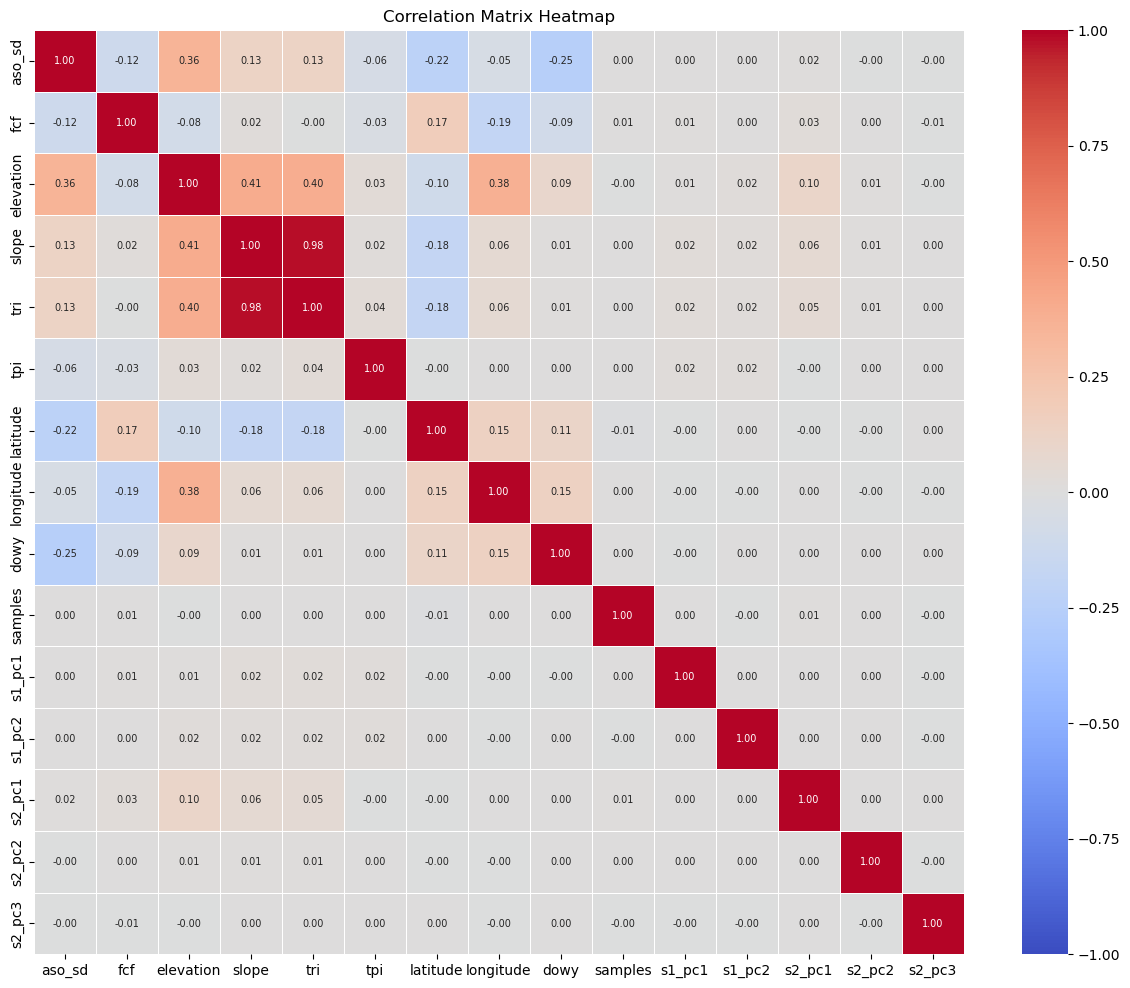

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",  linewidths=0.5, annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
# we see above that since we cleaned our data, the only two variables that are highly correlated (very highly correlated)
# are TRI and slope
# this makes sense as the two topographic features are similar, as TRI is an index that take sslope into account,
# yet understanding the topography of the surface underneath snow is wildly important for understand snowdepth so we keep it

In [ ]:
# the kernel died trying to run the below code with all of the data given there are ~58 million rows
# so we'll plot the data individually instead
columns_to_plot = df_all.columns[:13]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):
    sns.histplot(df_all[col], bins=256, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Snow Depth (m)')

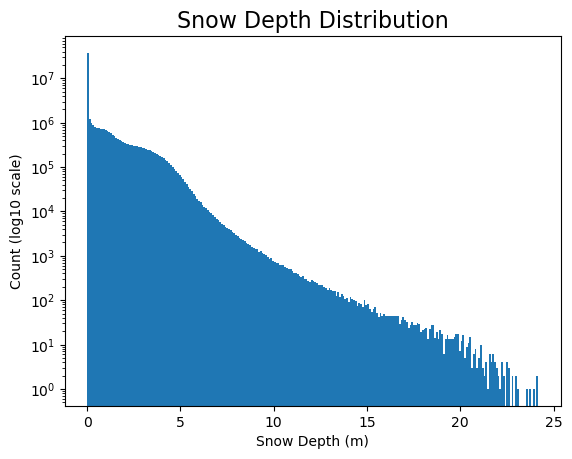

In [4]:
# some of the snow depth values below are ridiculously high, but we have to remember that some of these values
# are over the Olympics and some of these values were measured in 2023 wgucg was a record-setting snow year
plt.hist(df_all.aso_sd.values, bins=256);
plt.title("Snow Depth Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Snow Depth (m)')

Text(0.5, 0, 'Forest Cover Fraction')

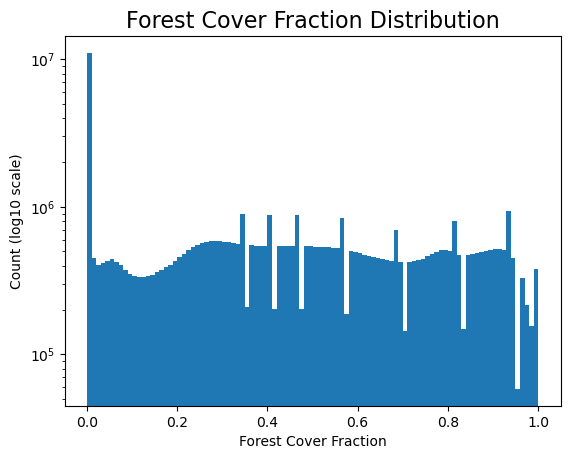

In [5]:
# most forest cover fraction values are between 0-0.1, makes sense for the mountains
plt.hist(df_all.fcf.values, bins=100);
plt.title("Forest Cover Fraction Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Forest Cover Fraction')

Text(0.5, 0, 'Elevation (m above EGM2008 geoid)')

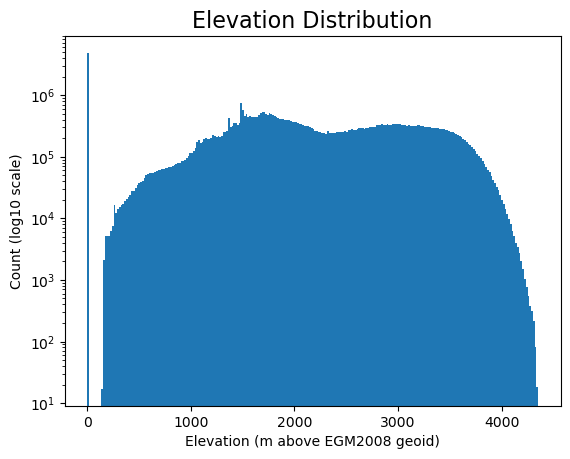

In [6]:
# most sites are in mountain rainges so high elevations make sense
# we see a lot of elevations at sea level too
plt.hist(df_all.elevation.values, bins=256);
plt.title("Elevation Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Elevation (m above EGM2008 geoid)')

Text(0.5, 0, 'Slope (degrees)')

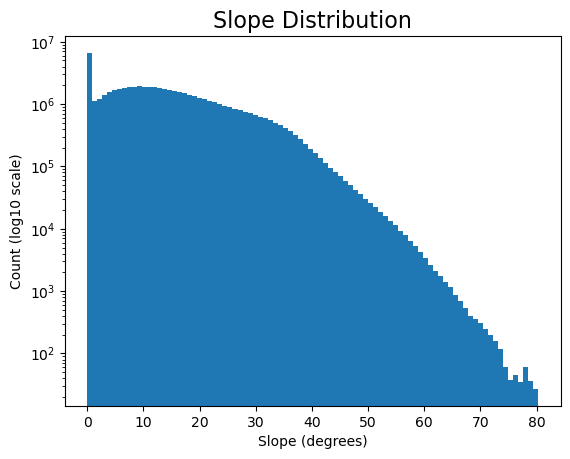

In [7]:
# not a lot of slope values between 60-90 degrees makes sense given 90 degrees is vertical
# also, 50mx50m cells so makes sense x2
plt.hist(df_all.slope.values, bins=90);
plt.title("Slope Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Slope (degrees)')

In [18]:
df_all.columns

Index(['aso_sd', 'fcf', 'elevation', 'slope', 'tri', 'tpi', 'latitude',
       'longitude', 'dowy', 'samples', 's1_pc1', 's1_pc2', 's2_pc1', 's2_pc2',
       's2_pc3'],
      dtype='object')

Text(0.5, 0, 'TRI')

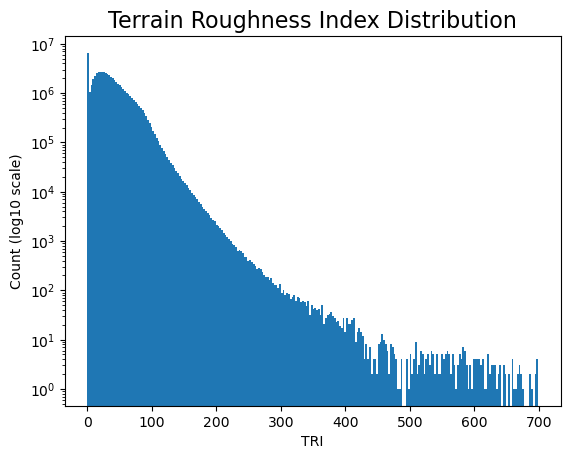

In [8]:
# TRI is a similar shape to slope, makes sense
plt.hist(df_all.tri.values, bins=256);
plt.title("Terrain Roughness Index Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('TRI')

Text(0.5, 0, 'TPI')

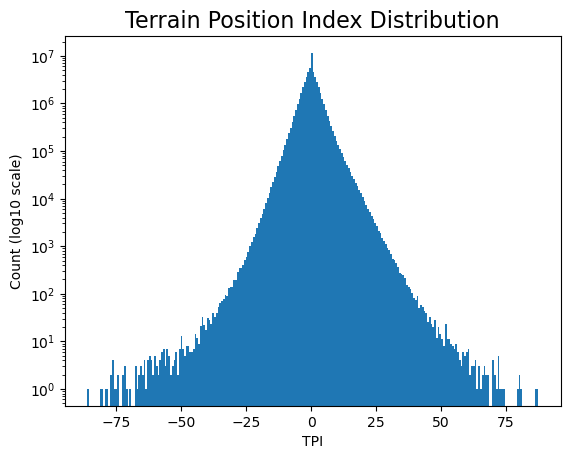

In [9]:
# TPI being normally distributed makes sense
plt.hist(df_all.tpi.values, bins=256);
plt.title("Terrain Position Index Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('TPI')

In [ ]:
# i won't plot the latitude and longitude values
# mapping the extents of the data themselves takes too long on this local machine too
# we know that our data is mostly in the Sierra Nevada mountain range (California), Rocky Mountains (Colorado), 
# and the Olympic Mountains (Washington) with some observations in southern Idaho
# Idaho and the Olympics are quite different in terms of snowpack and climate than the other two ranges
# which is difficult given we want to make a generalized model

Text(0.5, 0, 'Principal Component 1 Value')

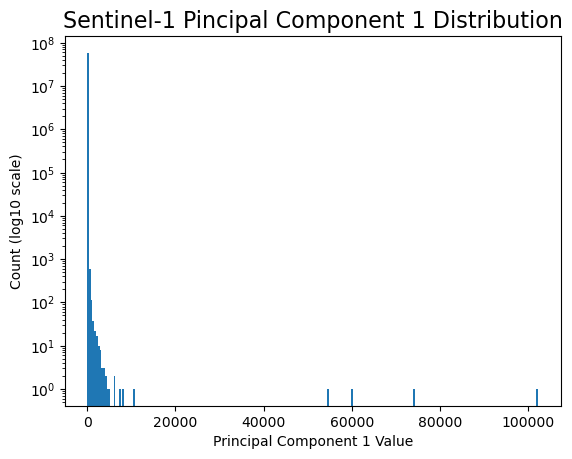

In [11]:
# sentinel-1 principal component 1 has a few weird outliers that we'll handle
plt.hist(df_all.s1_pc1.values, bins=256);
plt.title("Sentinel-1 Pincipal Component 1 Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Principal Component 1 Value')

Text(0.5, 0, 'Principal Component 2 Value')

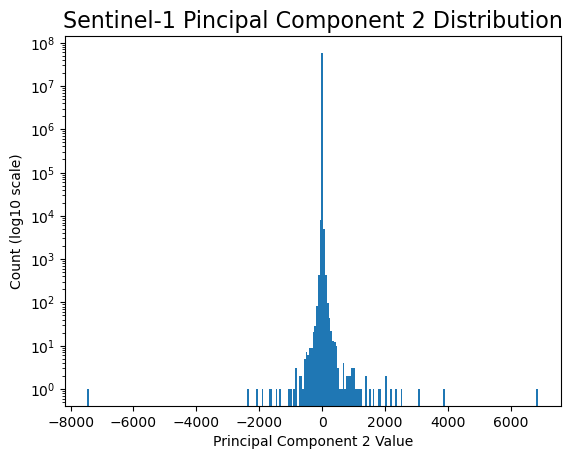

In [12]:
# sentinel-1 principal component 2 has a few weird outliers that we'll handle
plt.hist(df_all.s1_pc2.values, bins=256);
plt.title("Sentinel-1 Pincipal Component 2 Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Principal Component 2 Value')

Text(0.5, 0, 'Principal Component 1 Value')

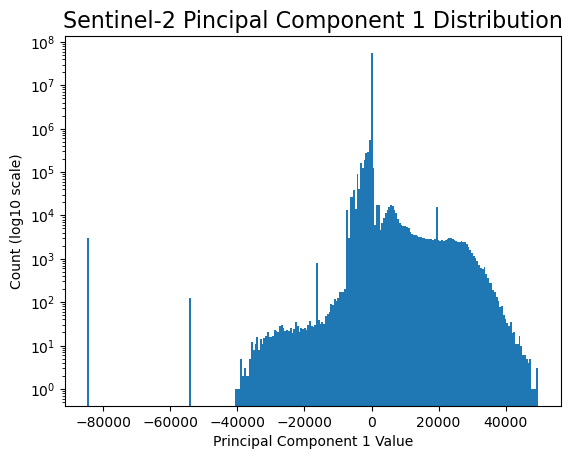

In [13]:
# sentinel-2 principal component 1 has a few weird outliers that we'll handle
plt.hist(df_all.s2_pc1.values, bins=256);
plt.title("Sentinel-2 Pincipal Component 1 Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Principal Component 1 Value')

Text(0.5, 0, 'Principal Component 2 Value')

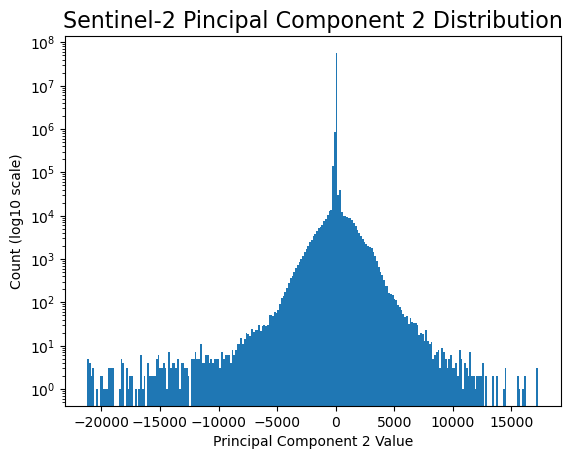

In [14]:
# sentinel-2 principal component 2 has a more than a few weird outliers
plt.hist(df_all.s2_pc2.values, bins=256);
plt.title("Sentinel-2 Pincipal Component 2 Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Principal Component 2 Value')

Text(0.5, 0, 'Principal Component 3 Value')

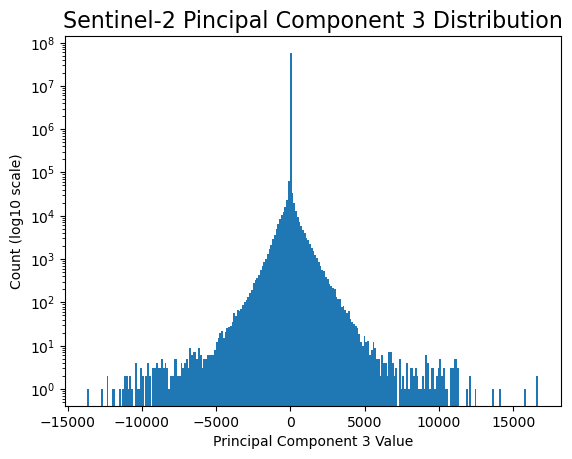

In [15]:
# sentinel-2 principal component 3 has a few weird outliers that we'll handle
plt.hist(df_all.s2_pc3.values, bins=256);
plt.title("Sentinel-2 Pincipal Component 3 Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Principal Component 3 Value')

Text(0.5, 0, 'Day of Water Year')

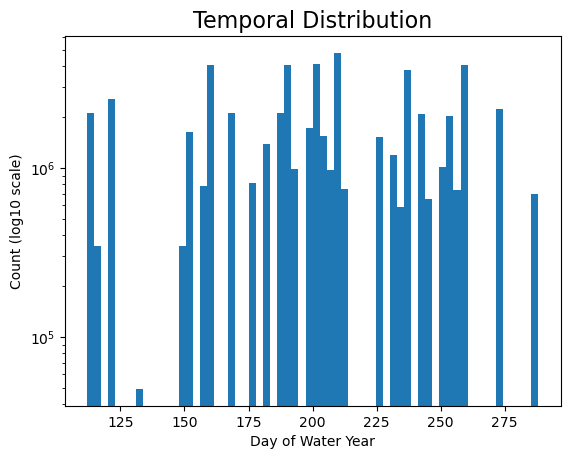

In [18]:
# sentinel-2 principal component 3 has a few weird outliers that we'll handle
plt.hist(df_all.dowy.values, bins=64);
plt.title("Temporal Distribution", fontsize=16)
plt.yscale('log')
plt.ylabel('Count (log10 scale)')
plt.xlabel('Day of Water Year')

#### Problem Setup (3%): Clearly defines the problem (e.g., regression/classification) and aligns the data with deep learning requirements (e.g., reshaping for CNNs, sequence creation for RNNs).

In [ ]:
# This is a regression problem for spatially predicting snowdepth on a grid, so we'll use a CNN
# as seen below, all of the files are xarray datasets of size 128x128 where each pixels is a 5omx50m
# cell with 12 feature variables and 1 target variable
# where each file is one sample

In [4]:
# see all the 12 features and 1 target (target being aso_sd)
ds = xr.open_dataset(files[0])
ds

<xarray.Dataset> Size: 1MB
Dimensions:    (x: 128, y: 128, samples: 16384)
Dimensions without coordinates: x, y, samples
Data variables: (12/14)
    aso_sd     (x, y) float32 66kB ...
    fcf        (x, y) float64 131kB ...
    elevation  (x, y) float32 66kB ...
    slope      (x, y) float64 131kB ...
    tri        (x, y) float64 131kB ...
    tpi        (x, y) float64 131kB ...
    ...         ...
    s1_pc1     (samples) float32 66kB ...
    s1_pc2     (samples) float32 66kB ...
    s2_pc1     (samples) float32 66kB ...
    s2_pc2     (samples) float32 66kB ...
    s2_pc3     (samples) float32 66kB ...
    dowy       (x, y) int64 131kB ...

In [8]:
import random
random_indices = random.sample(range(len(files)), 5)
# using random numbers above to show the consistent size of the data
for idx in random_indices:
    ds = xr.open_dataset(files[idx])
    print(ds.sizes)

Frozen({'x': 128, 'y': 128, 'samples': 16384})
Frozen({'x': 128, 'y': 128, 'samples': 16384})
Frozen({'x': 128, 'y': 128, 'samples': 16384})
Frozen({'x': 128, 'y': 128, 'samples': 16384})
Frozen({'x': 128, 'y': 128, 'samples': 16384})


# 2. Model Benchmarking Against CML (10%)

#### Baseline Models (5%): Reports results from previous classical machine learning benchmarks (e.g., random forests, SVMs, or gradient boosting) with minimal additional work.

In [16]:
# due to the structure of our data being geospatial, classic ml is not the most convenient approach
# that being said, let's convert our AI-ready dataset into a dataframe for the sake of the assignment
all_dataframes = []
for f in tqdm(files):
    ds = xr.open_dataset(f)
    df_2d = ds.drop_dims('samples', errors='ignore').to_dataframe().reset_index()
    df_1d = ds.drop_dims(['x', 'y'], errors='ignore').to_dataframe().reset_index()
    merged_df = pd.concat([df_2d, df_1d], axis=1)
    all_dataframes.append(merged_df)
final_dataframe = pd.concat(all_dataframes, ignore_index=True)

  0%|          | 0/3540 [00:00<?, ?it/s]

100%|██████████| 3540/3540 [09:59<00:00,  5.91it/s]


In [20]:
final_dataframe.drop(columns=['x', 'y'], axis=1).to_parquet("/mnt/c/Users/Jacke/uw/courses/aut24/ml_geo/final_cml_data.parquet")

In [21]:
df = final_dataframe.drop(columns=['x', 'y'], axis=1)

In [22]:
# nearly 58 million rows
# that will be kind of ridiculous in terms of processing time for tree-based CML models
# and given that our final project is focused on CNNs, we'll use a subset of this data and quicker CML algortihms
df.shape

(57999360, 15)

In [ ]:
# doing the below scaling on the entire dataframe killed my kernel, so we'll just do it on a subset of the data
# *and I have 64 gb of ram on my local machine :)
df = pd.read_parquet("/mnt/c/Users/Jacke/uw/courses/aut24/ml_geo/final_cml_data.parquet")
# shuffle df and only keep the first 32505856 rows
# we choose this odd number because this is the same percentage of files that we use in our deep learning exploration
df = df.sample(frac=1, random_state=42).reset_index(drop=True)[:32505856]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_to_normalize = [col for col in df.columns if col != 'aso_sd']
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

In [45]:
y = df.iloc[:,0].values
data = df.iloc[:, 1:].values
from sklearn.model_selection import train_test_split
# Split data into 80% train and 20% test subsets
print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=True)

There are 32505856 data samples


In [5]:
from sklearn import metrics
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor
# ElasticNet Regressor
en_reg = ElasticNet()
en_reg.fit(X_train, y_train) 
en_prediction = en_reg.predict(X_test)
print("ElasticNet Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=en_prediction))
# Ridge Regressor
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_prediction = ridge_reg.predict(X_test)
print("Ridge Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=ridge_prediction))
# Lasso Regressor
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_prediction = lasso_reg.predict(X_test)
print("Lasso Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=lasso_prediction))
# Dummy Regressor (Baseline)
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
dummy_prediction = dummy_reg.predict(X_test)
print("Dummy Regressor Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=dummy_prediction))
# Voting Regressor (Dummy and Ridge)
voting_reg = VotingRegressor(estimators=[('dummy', dummy_reg), ('ridge', ridge_reg)])
voting_reg.fit(X_train, y_train)
voting_prediction = voting_reg.predict(X_test)
print("Voting Regressor (Dummy + Ridge) Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=voting_prediction))

ElasticNet Mean Absolute Error: 0.8660045592833896
Ridge Mean Absolute Error: 0.7209619660308606
Lasso Mean Absolute Error: 0.8660045592833896
Dummy Regressor Mean Absolute Error: 0.6343305
Voting Regressor (Dummy + Ridge) Mean Absolute Error: 0.6458122267481049


#### Performance Comparison (5%): Provides a high-level comparison of CML methods to deep learning models using relevant metrics (e.g., accuracy, RMSE, F1-score).

In [6]:
print("ElasticNet Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, en_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, en_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, en_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, en_prediction))
print("\nRidge Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, ridge_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, ridge_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, ridge_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, ridge_prediction))
print("\nLasso Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, lasso_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, lasso_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, lasso_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, lasso_prediction))
print("\nDummy Regressor Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, dummy_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, dummy_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, dummy_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, dummy_prediction))
print("\nVoting Regressor (Dummy + Ridge) Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, voting_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, voting_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, voting_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, voting_prediction))

ElasticNet Metrics:
  MAE: 0.8660045592833896
  MSE: 1.4841194177488557
  RMSE: 1.2182443998430101
  R²: -2.2197190747696993e-06

Ridge Metrics:
  MAE: 0.7209619660308606
  MSE: 1.0734747741204407
  RMSE: 1.0360862773536
  R²: 0.27669084839470237

Lasso Metrics:
  MAE: 0.8660045592833896
  MSE: 1.4841194177488557
  RMSE: 1.2182443998430101


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is 

  R²: -2.2197190747696993e-06

Dummy Regressor Metrics:
  MAE: 0.6343305
  MSE: 1.8864914
  RMSE: 1.373496
  R²: -0.27112138271331787

Voting Regressor (Dummy + Ridge) Metrics:
  MAE: 0.6458122267481049
  MSE: 1.2775651768278415
  RMSE: 1.1302942877091087
  R²: 0.13917438355366551


/home/jehayes/mambaforge/envs/deep-snow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# The MAE of all of the CML models are terrible, having a MAE of 0.6-0.8 METERS of snow depth is unacceptable

In [ ]:
# note that ther kernel below died on a machine with 64gb RAM
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

# Random Forest Regressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_prediction = rf_reg.predict(X_test)
print("Random Forest Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=rf_prediction))

# Support Vector Regressor
svr_reg = SVR()
svr_reg.fit(X_train, y_train)
svr_prediction = svr_reg.predict(X_test)
print("Support Vector Regressor Mean Absolute Error:", metrics.mean_absolute_error(y_true=y_test, y_pred=svr_prediction))

# Metrics for Random Forest Regressor
print("\nRandom Forest Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, rf_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, rf_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, rf_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, rf_prediction))

# Metrics for Support Vector Regressor
print("\nSupport Vector Regressor Metrics:")
print("  MAE:", metrics.mean_absolute_error(y_test, svr_prediction))
print("  MSE:", metrics.mean_squared_error(y_test, svr_prediction))
print("  RMSE:", metrics.mean_squared_error(y_test, svr_prediction, squared=False))
print("  R²:", metrics.r2_score(y_test, svr_prediction))

: 

# 3. Model Architecture Exploration (35%)

#### Implementation and Justification (8%): Implements at least three deep learning architectures (e.g., FCN, CNN, RNN, U-Net). Justifies architecture choice based on dataset and problem type.

In [3]:
# first, let's just create a basic data pipeline to feed into a standard CNN
from torch.utils.data import DataLoader, TensorDataset, random_split
from deep_snow.dataset import norm_dict
from deep_snow.utils import calc_norm, undo_norm

In [4]:
norm_dict = {'aso_sd':[0, 25],
             'vv':[-59, 30],
             'vh':[-65, 17],
             'cr':[-43, 16],
             'delta_cr':[-33, 27],
             'AOT':[0, 572],
             'coastal':[0, 24304],
             'blue':[0, 23371],
             'green':[0, 26440],
             'red':[0, 21576],
             'red_edge1':[0, 20796],
             'red_edge2':[0, 20432],
             'red_edge3':[0, 20149],
             'nir':[0, 21217],
             'water_vapor':[0, 18199],
             'swir1':[0, 17669],
             'swir2':[0, 17936],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6518],
             'elevation':[-100, 9000],
             'aspect':[0, 360],
             'slope':[0, 90],
             'curvature':[-22, 22],
             'tpi':[-164, 167],
             'tri':[0, 913],
             'latitude':[-90, 90],
             'longitude':[-180, 180],
             'dowy': [0, 365]}

In [5]:
# Process each file and normalize the relevant features
def process_file(file_path):
    ds = xr.open_dataset(file_path)
    # Normalize features using the norm_dict
    data_dict = {}
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['slope'] = calc_norm(torch.Tensor(ds['slope'].values), norm_dict['slope'])
    data_dict['tri'] = calc_norm(torch.Tensor(ds['tri'].values), norm_dict['tri'])
    data_dict['tpi'] = calc_norm(torch.Tensor(ds['tpi'].values), norm_dict['tpi'])
    data_dict['dowy'] = calc_norm(torch.Tensor(ds['dowy'].values), norm_dict['dowy'])
    data_dict['fcf'] = torch.Tensor(ds['fcf'].values)
    # Reshape PC components to 2D
    s1_pc1_2d = ds['s1_pc1'].values.reshape(128, 128)
    s1_pc2_2d = ds['s1_pc2'].values.reshape(128, 128)
    s2_pc1_2d = ds['s2_pc1'].values.reshape(128, 128)
    s2_pc2_2d = ds['s2_pc2'].values.reshape(128, 128)
    s2_pc3_2d = ds['s2_pc3'].values.reshape(128, 128)
    # Stack normalized features
    features = np.stack([
        data_dict['elevation'].numpy(),
        data_dict['slope'].numpy(),
        data_dict['tri'].numpy(),
        data_dict['tpi'].numpy(),
        data_dict['latitude'].numpy(),
        data_dict['longitude'].numpy(),
        s1_pc1_2d,
        s1_pc2_2d,
        s2_pc1_2d,
        s2_pc2_2d,
        s2_pc3_2d,
        data_dict['fcf'].numpy(),
        data_dict['dowy'].numpy()
    ], axis=0)
    target = ds['aso_sd'].values
    return features, target

# Create datasets and data loaders
def create_dataset(file_list):
    features_list = []
    targets_list = []
    for file in file_list:
        features, target = process_file(file)
        features_list.append(torch.FloatTensor(features))
        targets_list.append(torch.FloatTensor(target))
    features_tensor = torch.stack(features_list)
    targets_tensor = torch.stack(targets_list)
    return TensorDataset(features_tensor, targets_tensor)

In [6]:
import random
# Split files into train, test, and validation sets
random.shuffle(files)
# let's use a subset of our files for initial model exploration
# 1984 since we have batches sizes of 32
files_subset = files[:1984]
# Calculate the sizes for each split
train_size = int(0.7 * len(files_subset))  # 70% for training
test_size = int(0.2 * len(files_subset))   # 20% for testing
val_size = len(files_subset) - train_size - test_size  # Remaining 10% for validation
# Create the splits
train_files = files_subset[:train_size]
test_files = files_subset[train_size:train_size + test_size]
val_files = files_subset[train_size + test_size:]
# Create datasets
train_dataset = create_dataset(train_files)
test_dataset = create_dataset(test_files)
val_dataset = create_dataset(val_files)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# Print shapes for training loader
for features, targets in train_loader:
    print("Training batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break
# Print shapes for test loader
for features, targets in test_loader:
    print("\nTest batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break
# Print shapes for validation loader
for features, targets in val_loader:
    print("\nValidation batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break

Training batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])

Test batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])

Validation batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])


In [8]:
# start off with a basic, 3-layer cnn
class SnowDepthCNN(nn.Module):
    def __init__(self):
        super(SnowDepthCNN, self).__init__()
        # First conv layer: (12, 128, 128) -> (32, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Second conv layer: (32, 128, 128) -> (16, 128, 128)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        # Final conv layer: (16, 128, 128) -> (1, 128, 128)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape

In [10]:
# and let's make a 'master' train_and_evaluate_model() function
import psutil
import time

def train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device, verbose=True
):
    """
    Train, validate, and test the model.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (Loss): The loss function.
        optimizer (Optimizer): The optimizer for model training.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use for computation.
        verbose (bool): If True, prints progress and displays plots.

    Returns:
        tuple: A tuple containing:
            - train_losses (list): Training losses over epochs.
            - val_losses (list): Validation losses over epochs.
            - final_test_loss (float): Final test loss.
            - test_mae (float): Mean Absolute Error on test set.
            - test_r2 (float): R-squared on test set.
            - test_rmse (float): Root Mean Squared Error on test set.
            - loss_fig (matplotlib.figure.Figure): Figure of training vs validation loss (None if verbose=False).
            - ram_fig (matplotlib.figure.Figure): Figure of RAM usage vs time (None if verbose=False).
    """
    train_losses = []
    val_losses = []
    ram_usage = []
    timestamps = []

    def record_ram_usage():
        """Record current RAM usage and timestamp."""
        ram_usage.append(psutil.virtual_memory().used / (1024 ** 3))  # Convert bytes to GB
        timestamps.append(time.time() - start_time)

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        loader = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}") if verbose else train_loader
        for features, targets in loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            record_ram_usage()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, targets).item()
                record_ram_usage()

        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f"Epoch [{epoch + 1}/{num_epochs}]")
            print(f"Training Loss: {avg_train_loss:.4f}")
            print(f"Validation Loss: {avg_val_loss:.4f}")

    # Testing
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Flatten the list of predictions and targets for MAE calculation
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate Test Metrics
    test_mae = np.mean(np.abs(all_preds - all_targets))
    test_rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    ss_total = np.sum((all_targets - np.mean(all_targets)) ** 2)
    ss_residual = np.sum((all_targets - all_preds) ** 2)
    test_r2 = 1 - (ss_residual / ss_total)
    final_test_loss = test_loss / len(test_loader)

    if verbose:
        # Plot Training vs Validation Loss
        loss_fig, ax1 = plt.subplots(figsize=(8, 6))
        ax1.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
        ax1.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", linestyle="--")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training vs Validation Loss")
        ax1.legend()
        ax1.grid(True)

        # Plot RAM Usage Over Time
        ram_fig, ax2 = plt.subplots(figsize=(8, 6))
        ax2.plot(timestamps, ram_usage, label="RAM Usage", color="orange")
        ax2.set_xlabel("Time (seconds)")
        ax2.set_ylabel("RAM Usage (GB)")
        ax2.set_title("RAM Usage Over Time")
        ax2.grid(True)
        ax2.legend()
    else:
        loss_fig, ram_fig = None, None

    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    return train_losses, val_losses, final_test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig

Epoch 1: 100%|██████████| 44/44 [00:08<00:00,  5.44it/s]


Epoch [1/15]
Training Loss: 1.4006
Validation Loss: 3.3645


Epoch 2: 100%|██████████| 44/44 [00:08<00:00,  5.49it/s]


Epoch [2/15]
Training Loss: 1.2218
Validation Loss: 1.9278


Epoch 3: 100%|██████████| 44/44 [00:07<00:00,  5.57it/s]


Epoch [3/15]
Training Loss: 0.8699
Validation Loss: 0.7713


Epoch 4: 100%|██████████| 44/44 [00:07<00:00,  5.52it/s]


Epoch [4/15]
Training Loss: 0.7583
Validation Loss: 0.5980


Epoch 5: 100%|██████████| 44/44 [00:07<00:00,  5.50it/s]


Epoch [5/15]
Training Loss: 0.8366
Validation Loss: 1.1141


Epoch 6: 100%|██████████| 44/44 [00:08<00:00,  5.48it/s]


Epoch [6/15]
Training Loss: 0.9014
Validation Loss: 0.8225


Epoch 7: 100%|██████████| 44/44 [00:07<00:00,  5.63it/s]


Epoch [7/15]
Training Loss: 0.7149
Validation Loss: 0.7490


Epoch 8: 100%|██████████| 44/44 [00:08<00:00,  5.45it/s]


Epoch [8/15]
Training Loss: 0.6698
Validation Loss: 0.6709


Epoch 9: 100%|██████████| 44/44 [00:08<00:00,  5.16it/s]


Epoch [9/15]
Training Loss: 0.6544
Validation Loss: 0.5715


Epoch 10: 100%|██████████| 44/44 [00:09<00:00,  4.53it/s]


Epoch [10/15]
Training Loss: 0.6401
Validation Loss: 0.5565


Epoch 11: 100%|██████████| 44/44 [00:09<00:00,  4.70it/s]


Epoch [11/15]
Training Loss: 0.6379
Validation Loss: 0.5111


Epoch 12: 100%|██████████| 44/44 [00:09<00:00,  4.75it/s]


Epoch [12/15]
Training Loss: 0.6290
Validation Loss: 0.5454


Epoch 13: 100%|██████████| 44/44 [00:09<00:00,  4.52it/s]


Epoch [13/15]
Training Loss: 0.6437
Validation Loss: 0.5097


Epoch 14: 100%|██████████| 44/44 [00:09<00:00,  4.63it/s]


Epoch [14/15]
Training Loss: 0.6280
Validation Loss: 0.5098


Epoch 15: 100%|██████████| 44/44 [00:09<00:00,  4.67it/s]


Epoch [15/15]
Training Loss: 0.6270
Validation Loss: 0.5134
Final Test Loss: 0.6230
Test MAE: 0.6283
Test RMSE: 1.3351
Test R²: -0.2170


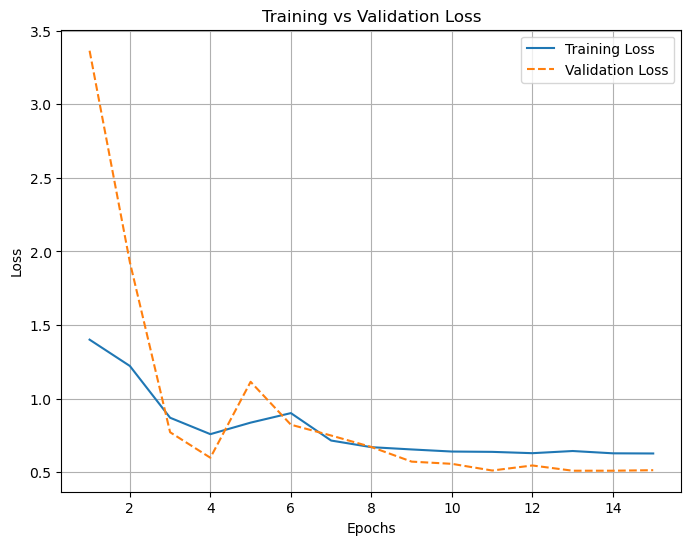

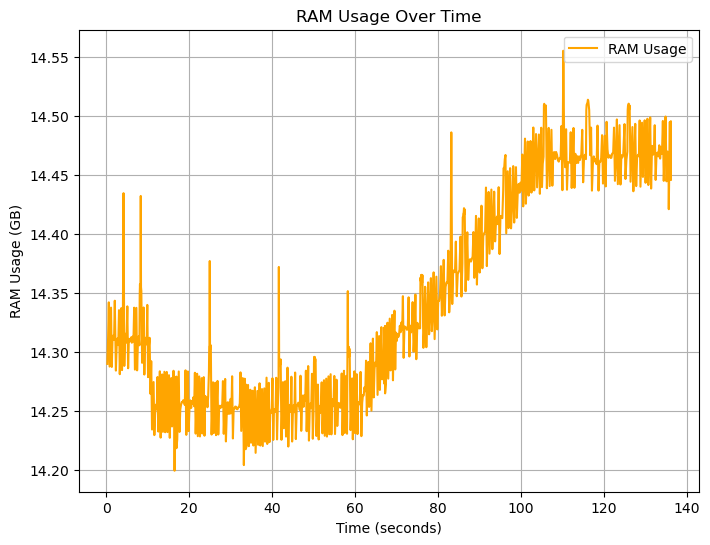

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model, loss function, optimizer, and device
model = SnowDepthCNN().to(device)
criterion = nn.L1Loss()  # MAE Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15
# Train, validate, and test the model
train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

In [ ]:
# great, we have a basic CNN implemented
# we see that the resulting MAE of 0.6283 meters is unacceptable when it comes to snow depth estimation
# and a negative R2 value... that's rough
# we also see that we should likely use more epochs, but since we're only working with a subset of the data for model evaluation purposes
# we'll scale up and use the entire dataset and more epochs once we find the 'best' parameters for this subset
# now let's explore other architectures for a preliminary search for the best architecture for our problem

In [14]:
# UNet Model Definition
class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoding path
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoding path
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2)
        
        # Decoding
        dec2 = self.upsample2(bottleneck)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upsample1(dec2)
        dec1 = self.dec1(dec1)
        
        output = self.final(dec1)
        return output.squeeze(1)  # Match the output shape [batch_size, 128, 128]

Epoch 1: 100%|██████████| 44/44 [03:13<00:00,  4.41s/it]


Epoch [1/10]
Training Loss: 0.7176
Validation Loss: 0.5961


Epoch 2: 100%|██████████| 44/44 [03:11<00:00,  4.36s/it]


Epoch [2/10]
Training Loss: 0.7252
Validation Loss: 0.5961


Epoch 3: 100%|██████████| 44/44 [02:48<00:00,  3.82s/it]


Epoch [3/10]
Training Loss: 0.7137
Validation Loss: 0.5961


Epoch 4: 100%|██████████| 44/44 [02:48<00:00,  3.82s/it]


Epoch [4/10]
Training Loss: 0.7200
Validation Loss: 0.5961


Epoch 5: 100%|██████████| 44/44 [02:49<00:00,  3.85s/it]


Epoch [5/10]
Training Loss: 0.7155
Validation Loss: 0.5961


Epoch 6: 100%|██████████| 44/44 [02:51<00:00,  3.90s/it]


Epoch [6/10]
Training Loss: 0.7259
Validation Loss: 0.5961


Epoch 7: 100%|██████████| 44/44 [02:43<00:00,  3.72s/it]


Epoch [7/10]
Training Loss: 0.7121
Validation Loss: 0.5961


Epoch 8: 100%|██████████| 44/44 [02:53<00:00,  3.94s/it]


Epoch [8/10]
Training Loss: 0.7125
Validation Loss: 0.5961


Epoch 9: 100%|██████████| 44/44 [02:35<00:00,  3.53s/it]


Epoch [9/10]
Training Loss: 0.7209
Validation Loss: 0.5961


Epoch 10: 100%|██████████| 44/44 [02:27<00:00,  3.35s/it]


Epoch [10/10]
Training Loss: 0.7188
Validation Loss: 0.5961
Final Test Loss: 0.7121
Test MAE: 0.7187
Test RMSE: 1.4072
Test R²: -0.3520


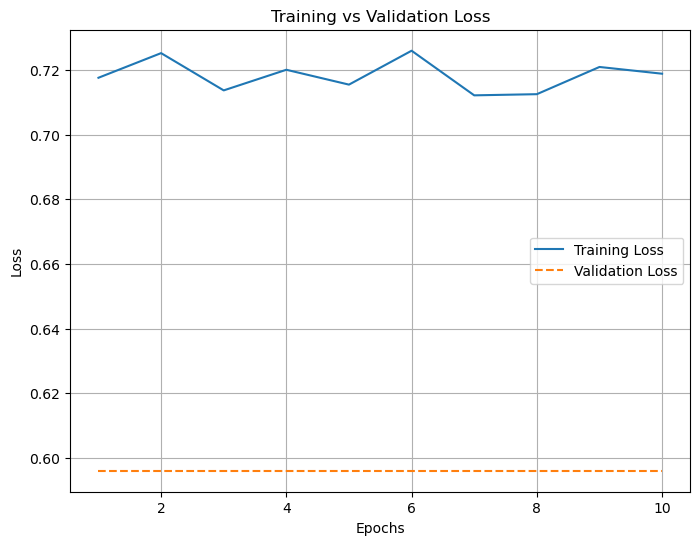

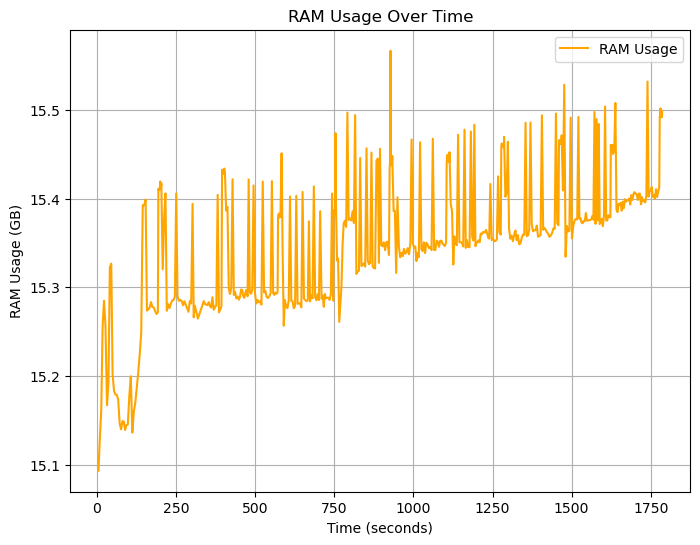

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = UNet(in_channels=13, out_channels=1).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# note that we only use 10 epochs for Unet
# i've rewritten the code in this notebook and ran these tests many times and I know that
# Unet and resnet are not worth it in terms of processing time
# so here, we do an extra abridged version
num_epochs = 10
train_losses_unet, val_losses_unet, test_loss_unet, test_mae_unet, test_r2_unet, test_rmse_unet, loss_fig_unet, ram_fig_unet = train_and_evaluate_model(
    model=unet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

In [ ]:
# hmm that doesn't seem right
# the training loss actually converged when we used the entire dataset for training, maybe it's a data issue
# that being said, we'll write off the UNet for this assignment as that took 30 minutes to run
# and we'll have to do a lot of hyperparameter tuning for this assignement

# in the real world, I'd correct this error and proceed again, but given the time constraints, I'll move on
# we'd be sitting here for a lot more hours than necessary if we were to correct the UNet and tune the hyperparameters on that model

In [19]:
# our third architecture to explore will be a resnet
# Residual Block and ResNet for Snow Depth Estimation
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)
        self.shortcut = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + shortcut)

class ResNetSnowDepth(nn.Module):
    def __init__(self):
        super(ResNetSnowDepth, self).__init__()
        # Initial convolution: (13, 128, 128) -> (32, 128, 128)
        self.initial_conv = nn.Conv2d(13, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Residual blocks
        self.res1 = ResidualBlock(32, 64)  # (32, 128, 128) -> (64, 128, 128)
        self.res2 = ResidualBlock(64, 128)  # (64, 128, 128) -> (128, 128, 128)
        self.res3 = ResidualBlock(128, 64)  # (128, 128, 128) -> (64, 128, 128)
        # Output layer: (64, 128, 128) -> (1, 128, 128)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        x = self.relu(self.initial_conv(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.output_conv(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape

Epoch 1:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 44/44 [02:56<00:00,  4.01s/it]


Epoch [1/10]
Training Loss: 0.8534
Validation Loss: 0.5100


Epoch 2: 100%|██████████| 44/44 [03:20<00:00,  4.57s/it]


Epoch [2/10]
Training Loss: 0.6245
Validation Loss: 0.5030


Epoch 3: 100%|██████████| 44/44 [03:25<00:00,  4.66s/it]


Epoch [3/10]
Training Loss: 0.6291
Validation Loss: 0.5026


Epoch 4: 100%|██████████| 44/44 [03:22<00:00,  4.60s/it]


Epoch [4/10]
Training Loss: 0.6211
Validation Loss: 0.5026


Epoch 5: 100%|██████████| 44/44 [03:10<00:00,  4.32s/it]


Epoch [5/10]
Training Loss: 0.6429
Validation Loss: 0.5028


Epoch 6: 100%|██████████| 44/44 [03:25<00:00,  4.68s/it]


Epoch [6/10]
Training Loss: 0.6251
Validation Loss: 0.5036


Epoch 7: 100%|██████████| 44/44 [03:28<00:00,  4.74s/it]


Epoch [7/10]
Training Loss: 0.6267
Validation Loss: 0.5194


Epoch 8: 100%|██████████| 44/44 [03:23<00:00,  4.62s/it]


Epoch [8/10]
Training Loss: 0.6066
Validation Loss: 0.4817


Epoch 9: 100%|██████████| 44/44 [03:18<00:00,  4.52s/it]


Epoch [9/10]
Training Loss: 0.5879
Validation Loss: 0.4617


Epoch 10: 100%|██████████| 44/44 [03:14<00:00,  4.42s/it]


Epoch [10/10]
Training Loss: 0.5676
Validation Loss: 0.4606
Final Test Loss: 0.5793
Test MAE: 0.5845
Test RMSE: 1.2278
Test R²: -0.0292


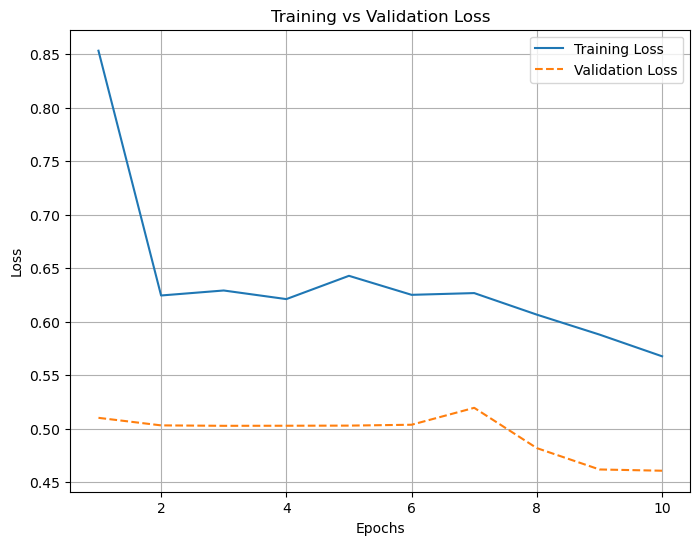

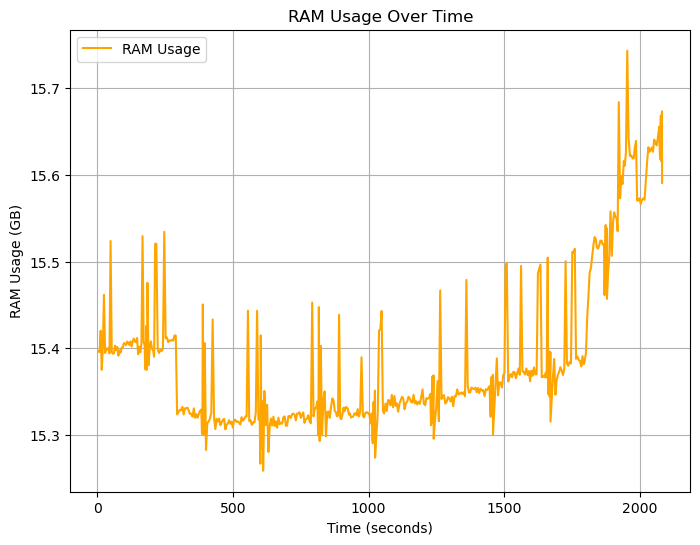

In [20]:
# Training Setup for ResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = ResNetSnowDepth().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
# note that we only use 10 epochs for Unet
# i've rewritten the code in this notebook and ran these tests many times and I know that
# Unet and resnet are not worth it in terms of processing time
# so here, we do an extra abridged version
num_epochs = 10
train_losses_resnet, val_losses_resnet, test_loss_resnet, test_mae_resnet, test_r2_resnet, test_rmse_resnet, loss_fig_resnet, ram_fig_resnet = train_and_evaluate_model(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

In [ ]:
# above we see that the ResNet model is the best performing model and quite promising, but we also see that it takes
# 35 minutes to run a simple ResNet architecture as opposed to 30 minutes for a U-net and under 3 minutes for a 
# basic CNN.
# 35 minutes isn't a long runtime at all, but given that this is for a homework assignemnt that requires hyperparameter tuning
# we'll proceed with the simple CNN architecture rather than the ResNet architecture so we don't have to wait a lot of hours for 
# hyperparameter tuning. Running ResNet tuning overnight will be interesting, and something to explore, but for the sake of the assingment
# deadline, we can't risk an error or bug interrupting this

#### Parameter Tuning (8%): Explores hyperparameters (e.g., learning rate, number of layers, filter sizes) and documents experiments systematically.

In [26]:
import itertools
# Define the hyperparameter grid
learning_rates = [0.001, 0.0005, 0.0001]
num_layers_options = [3, 4, 5]
filter_sizes_options = [16, 32, 64]

# Results storage
tuning_results = []

# Define a function to create the model with variable layers and filter sizes
def create_model(num_layers, initial_filter_size):
    layers = []
    in_channels = 13
    for i in range(num_layers):
        out_channels = initial_filter_size if i == 0 else in_channels // 2
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    # Add the final layer
    layers.append(nn.Conv2d(in_channels, 1, kernel_size=1))
    return nn.Sequential(*layers)

# Train and evaluate models with different hyperparameters
for lr, num_layers, filter_size in itertools.product(learning_rates, num_layers_options, filter_sizes_options):
    print(f"\nTraining with learning rate={lr}, num_layers={num_layers}, filter_size={filter_size}")
    
    # Create the model
    model = create_model(num_layers, filter_size)
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.L1Loss()  # MAE Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train the model
    train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device,
        verbose=False,  # Suppress progress for each epoch
    )
    
    # Record the results
    tuning_results.append({
        "learning_rate": lr,
        "num_layers": num_layers,
        "filter_size": filter_size,
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_loss": test_loss,
        "test_mae": test_mae,
        "test_r2": test_r2,
        "test_rmse": test_rmse,
    })

# Display the tuning results
print("\nHyperparameter Tuning Results:")
for result in tuning_results:
    print(result)


Training with learning rate=0.001, num_layers=3, filter_size=16
Final Test Loss: 0.6201
Test MAE: 0.6264
Test RMSE: 1.3620
Test R²: -500.6026

Training with learning rate=0.001, num_layers=3, filter_size=32
Final Test Loss: 0.6200
Test MAE: 0.6262
Test RMSE: 1.3612
Test R²: -499.9525

Training with learning rate=0.001, num_layers=3, filter_size=64
Final Test Loss: 0.6209
Test MAE: 0.6272
Test RMSE: 1.3593
Test R²: -498.6162

Training with learning rate=0.001, num_layers=4, filter_size=16
Final Test Loss: 0.6193
Test MAE: 0.6255
Test RMSE: 1.3617
Test R²: -500.3643

Training with learning rate=0.001, num_layers=4, filter_size=32
Final Test Loss: 0.6325
Test MAE: 0.6385
Test RMSE: 1.3508
Test R²: -492.3249

Training with learning rate=0.001, num_layers=4, filter_size=64
Final Test Loss: 0.6298
Test MAE: 0.6359
Test RMSE: 1.3660
Test R²: -503.5578

Training with learning rate=0.001, num_layers=5, filter_size=16
Final Test Loss: 0.7126
Test MAE: 0.7158
Test RMSE: 1.2568
Test R²: -426.1064

In [ ]:
# those are very concerning R2 values... 
# it kind of makes sense in terms of the physics of our problem? 
# our predictions might be clustered near zero since we have a huge class imbalance of most snow depth target values == 0
# but our snow depth targets have a wide variance
# that being said, why are these -500 while our first model with a similar architecture was -0.2

In [27]:
# Convert the tuning results to a DataFrame for better analysis
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df = tuning_results_df.sort_values(by='test_loss', ascending=True).reset_index(drop=True)
# Output the best combination of hyperparameters
best_combination = tuning_results_df.iloc[0]
lr_best = best_combination['learning_rate']
num_layers_best = best_combination['num_layers']
filter_size_best = best_combination['filter_size']

# Display the best hyperparameters
print(f"\nBest Hyperparameters: Learning Rate = {lr_best}, Num Layers = {num_layers_best}, Filter Size = {filter_size_best}")


Best Hyperparameters: Learning Rate = 0.001, Num Layers = 5.0, Filter Size = 32.0


In [29]:
tuning_results_df.head(10)

,learning_rate,num_layers,filter_size,train_loss,val_loss,test_loss,test_mae,test_r2,test_rmse
0,0.0010,5,32,0.627318,0.502277,0.619106,0.625545,-500.606995,1.362049
1,0.0005,5,16,0.626093,0.502295,0.619120,0.625548,-500.584229,1.362018
2,0.0010,5,64,0.625120,0.502311,0.619135,0.625558,-500.566589,1.361994
3,0.0010,4,16,0.628813,0.502508,0.619279,0.625547,-500.364319,1.361719
4,0.0005,5,64,0.625372,0.502541,0.619347,0.625667,-500.421722,1.361797
5,0.0001,4,16,0.622922,0.503034,0.619590,0.626021,-500.750275,1.362244
6,0.0010,3,32,0.626922,0.503312,0.619973,0.626161,-499.952454,1.361160
7,0.0010,3,16,0.628310,0.503535,0.620110,0.626364,-500.602631,1.362043
8,0.0001,3,16,0.621294,0.503107,0.620175,0.626653,-508.199036,1.372318
9,0.0010,3,64,0.627945,0.505298,0.620921,0.627150,-498.616241,1.359344


In [ ]:
# we see above that we'll proceed with a learning rate of 0.0005, 4 layers, and a filter size of 64

# edit: i'm realizing that after ~2 hours of hyperparameter tuning and moving onto  PI-loss
#  that the 'best' model returned here is still worse than our simplest CNN. 
# The PI-loss is implemented on the model seen in the table above rather than the simpler one
# that performs best. But further in this notebook, we go back to tuning the simpler, better model

#### Incorporation of Physics-Informed Loss (4%): Implements physics-informed loss where appropriate, with a clear explanation of its relevance to the geoscientific problem.

#### Innovation and Complexity (8%): Includes innovative approaches like hybrid architectures, custom loss functions, or data augmentation specific to geoscience applications.

In [25]:
# as seen in the notebook notebooks/application/jack_cnn_snotel.ipynb , we made another AI-ready dataset, this time using SNOTEL data
# SNOTEL is a system of snow depth measurements stations that are highly accurate, but very spatially sparse
# because of this, we only have 101 files which is very very small
# so we likely won't proceed with this approach, but we want to try and encode these SNOTEL point data into our CNNs
# where the point snow depth value from SNOTEL is represented as a separate feature in one of the 50x50m cells in the rasterized dataset
# so we'll try and calculate loss on these points

In [ ]:
# @Ayush - can you put the sparse supervision exploration here?

#### Exploration and Analysis (7%): Investigates losses, activation functions, and layer design, demonstrating a strong understanding of model behavior

In [ ]:
# let's go back to our classic CNN model to somewhat optimize the parameters requested

In [12]:
# Define the updated SnowDepthCNN with the best hyperparameters
class SnowDepthCNNBest(nn.Module):
    def __init__(self):
        super(SnowDepthCNNBest, self).__init__()
        self.relu = nn.ReLU()
        
        # Use 5 convolutional layers with the specified filter size (32)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)  # Final layer

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape


# Define loss function hyperparameter grid
loss_param_grid = {
    'reduction': ['mean', 'sum'],
    'beta': [0.5, 1.0, 2.0]  # Weight factor for the loss
}

# Results storage
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Grid search over loss function parameters
for reduction in loss_param_grid['reduction']:
    for beta in loss_param_grid['beta']:
        print(f"Training with reduction={reduction}, beta={beta}")
        
        # Initialize model with the correct architecture
        model = SnowDepthCNNBest().to(device)
        
        # Initialize loss with current parameters
        if beta == 1.0:
            criterion = nn.L1Loss(reduction=reduction)
        else:
            criterion = lambda x, y: beta * nn.L1Loss(reduction=reduction)(x, y)
        
        # Use the best learning rate
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Train and evaluate
        train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=10,
            device=device,
            verbose=False
        )
        
        # Store results
        results.append({
            'reduction': reduction,
            'beta': beta,
            'test_loss': test_loss,
            'final_val_loss': val_losses[-1],
            'test_mae': test_mae
        })
 
 # Find best configuration
best_result = min(results, key=lambda x: x['test_mae'])
print("\nBest loss function configuration:")
print(f"Reduction: {best_result['reduction']}")
print(f"Beta: {best_result['beta']}")
print(f"Test mae: {best_result['test_mae']:.4f}")

Training with reduction=mean, beta=0.5
Final Test Loss: 0.2607
Test MAE: 0.5193
Test RMSE: 1.0673
Test R²: 0.1752
Training with reduction=mean, beta=1.0
Final Test Loss: 0.5165
Test MAE: 0.5135
Test RMSE: 1.0572
Test R²: 0.1908
Training with reduction=mean, beta=2.0
Final Test Loss: 1.0468
Test MAE: 0.5212
Test RMSE: 1.0997
Test R²: 0.1244
Training with reduction=sum, beta=0.5
Final Test Loss: 137451.4925
Test MAE: 0.5508
Test RMSE: 1.0472
Test R²: 0.2061
Training with reduction=sum, beta=1.0
Final Test Loss: 255205.4862
Test MAE: 0.5113
Test RMSE: 1.0485
Test R²: 0.2040
Training with reduction=sum, beta=2.0
Final Test Loss: 516219.9519
Test MAE: 0.5172
Test RMSE: 1.0402
Test R²: 0.2166

Best loss function configuration:
Reduction: sum
Beta: 1.0
Test mae: 0.5113


In [ ]:
# ok that's a pretty solid improvement on MAE, we'll proceed with a beta of 1 and a 'sum' reduction for our L1 loss
# interestingly, training with reduction=sum, beta=0.5 revealed a better R squared score than our reduction=sum, beta=1.0
# but a much worse testing MAE

In [14]:
# now let's do activation functions
# and implement the new loss function parameter
class SnowDepthCNNBest(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(SnowDepthCNNBest, self).__init__()
        self.relu = nn.ReLU()
        
        # Use 5 convolutional layers with the specified filter size (32)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)  # Final layer
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.conv5(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape

# our optimized loss function
criterion = nn.L1Loss(reduction='sum')

# Test different activation functions
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.Sigmoid()]
results = []

for activation in activation_functions:
    model = SnowDepthCNNBest(activation=activation)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device,
        verbose=False
    )
    
    # Store results
    results.append({
        'activation': activation.__class__.__name__,
        'beta': beta,
        'test_loss': test_loss,
        'final_val_loss': val_losses[-1],
        'test_mae': test_mae
    })
 
 # Find best configuration
best_result = min(results, key=lambda x: x['test_mae'])
print("\nBest loss function configuration:")
print(f"Activation: {best_result['activation']}")
print(f"Beta: {best_result['beta']}")
print(f"Test mae: {best_result['test_mae']:.4f}")

Final Test Loss: 255850.4784
Test MAE: 0.5126
Test RMSE: 1.0533
Test R²: 0.1968
Final Test Loss: 262664.8233
Test MAE: 0.5263
Test RMSE: 1.1088
Test R²: 0.1099
Final Test Loss: 266263.9111
Test MAE: 0.5335
Test RMSE: 1.0783
Test R²: 0.1582
Final Test Loss: 300947.9964
Test MAE: 0.6030
Test RMSE: 1.2718
Test R²: -0.1710

Best loss function configuration:
Activation: ReLU
Beta: 2.0
Test mae: 0.5126


In [ ]:
# ignore the inclusion of 'Beta' above, this is always 2.0 from the previous loss function optimization code

In [ ]:
# So ReLU seems to be the best activation function for this problem, at least of the four we tested

In [ ]:
# Now let's test different layer designs (all 5 layer designs)
layer_configs = [
    # Current baseline
    [(13, 32), (32, 32), (32, 32), (32, 32), (32, 1)],
    # Wider throughout
    [(13, 64), (64, 64), (64, 64), (64, 64), (64, 1)],
    # Narrow to wide
    [(13, 16), (16, 32), (32, 32), (32, 32), (32, 1)],
    # Wide to narrow
    [(13, 128), (128, 64), (64, 32), (32, 16), (16, 1)]
]

results = []

for config in layer_configs:
    class SnowDepthCNNTest(nn.Module):
        def __init__(self, activation=nn.ReLU()):
            super(SnowDepthCNNTest, self).__init__()
            self.layers = nn.ModuleList([
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1)
                for in_ch, out_ch in config[:-1]
            ])
            # Final 1x1 conv layer
            self.final = nn.Conv2d(config[-2][1], config[-1][1], kernel_size=1)
            self.activation = activation

        def forward(self, x):
            for layer in self.layers:
                x = self.activation(layer(x))
            x = self.final(x)
            return x.squeeze(1)  # Remove channel dimension to match target shape

    model = SnowDepthCNNTest()
    model = model.to(device)
    criterion = nn.L1Loss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device,
        verbose=False
    )
    
    results.append({
        'config': config,
        'test_loss': test_loss,
        'final_val_loss': val_losses[-1],
        'test_mae': test_mae
    })

# Find best layer configuration
best_result = min(results, key=lambda x: x['test_loss'])
print("\nBest layer configuration:")
print(f"Layers: {best_result['config']}")
print(f"Test loss: {best_result['test_mae']:.4f}")

Final Test Loss: 277762.3401
Test MAE: 0.5565
Test RMSE: 1.0796
Test R²: 0.1561
Final Test Loss: 255178.3377
Test MAE: 0.5113
Test RMSE: 1.0396
Test R²: 0.2175
Final Test Loss: 269032.3215
Test MAE: 0.5391
Test RMSE: 1.0571
Test R²: 0.1910
Final Test Loss: 299541.3450
Test MAE: 0.6002
Test RMSE: 1.2885
Test R²: -0.2020

Best layer configuration:
Layers: [(13, 64), (64, 64), (64, 64), (64, 64), (64, 1)]
Test loss: 0.5113


In [ ]:
# Ignore the print statements, we see that the Test loss: 0.5113 is actually the teat MAE and is in fact the lowest MAE

In [ ]:
# Very interesting how much worse the first layer combination was compared to the previous run with the same parameters and layer config
# this definitely implies that our data subset and limited number of epochs affects the robustness of our hyperparameter
# tuning but there's not much we can do about that

In [16]:
# so we'll proceed with the original layer structure as seen above and finally optimize the optimizer
class SnowDepthCNNBest(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(SnowDepthCNNBest, self).__init__()
        self.relu = nn.ReLU()
        
        # Use 5 convolutional layers with the specified filter size (32)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)  # Final layer
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.conv5(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape

# Test different optimizers
optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD,
    'RMSprop': torch.optim.RMSprop,
    'AdamW': torch.optim.AdamW
}

results = []

for opt_name, opt_class in optimizers.items():
    model = SnowDepthCNNBest()
    model = model.to(device)
    criterion = nn.L1Loss(reduction='sum')
    
    # Handle SGD separately as it needs momentum
    if opt_name == 'SGD':
        optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)
    
    train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device,
        verbose=False
    )
    
    results.append({
        'optimizer': opt_name,
        'test_loss': test_loss,
        'final_val_loss': val_losses[-1],
        'test_mae': test_mae
    })

# Find best optimizer
best_result = min(results, key=lambda x: x['test_mae'])
print("\nBest optimizer configuration:")
print(f"Optimizer: {best_result['optimizer']}")
print(f"Test MAE: {best_result['test_mae']:.4f}")

Final Test Loss: 274047.0787
Test MAE: 0.5491
Test RMSE: 1.0521
Test R²: 0.1985
Final Test Loss: nan
Test MAE: nan
Test RMSE: nan
Test R²: nan
Final Test Loss: 257132.0228
Test MAE: 0.5152
Test RMSE: 1.0821
Test R²: 0.1522
Final Test Loss: 260364.2819
Test MAE: 0.5217
Test RMSE: 1.0656
Test R²: 0.1778

Best optimizer configuration:
Optimizer: RMSprop
Test MAE: 0.5152


In [ ]:
# seems like all of the losses we tested besides SGD are pretty comparable
# I would ideally do a comparison with k-fold validations and more epochs for each loss function
# but for the sake of time, let's just proceed with RMSprop

In [17]:
# now let's do all the data
# Split files into train, test, and validation sets
random.shuffle(files)
files_subset = files[:]
# Calculate the sizes for each split
train_size = int(0.7 * len(files_subset))  # 70% for training
test_size = int(0.2 * len(files_subset))   # 20% for testing
val_size = len(files_subset) - train_size - test_size  # Remaining 10% for validation
# Create the splits
train_files = files_subset[:train_size]
test_files = files_subset[train_size:train_size + test_size]
val_files = files_subset[train_size + test_size:]
# Create datasets
train_dataset = create_dataset(train_files)
test_dataset = create_dataset(test_files)
val_dataset = create_dataset(val_files)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [22]:
# Print shapes for training loader
for features, targets in train_loader:
    print("Training batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break
# Print shapes for test loader
for features, targets in test_loader:
    print("\nTest batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break
# Print shapes for validation loader
for features, targets in val_loader:
    print("\nValidation batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break

Training batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])

Test batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])

Validation batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])


Epoch 1/30: 100%|██████████| 78/78 [02:09<00:00,  1.66s/it]


Epoch [1/30]
Training Loss: 2184463.8861
Validation Loss: 327359.0859


Epoch 2/30: 100%|██████████| 78/78 [02:10<00:00,  1.67s/it]


Epoch [2/30]
Training Loss: 324540.3951
Validation Loss: 325609.3945


Epoch 3/30: 100%|██████████| 78/78 [02:06<00:00,  1.62s/it]


Epoch [3/30]
Training Loss: 322903.3685
Validation Loss: 324777.4824


Epoch 4/30: 100%|██████████| 78/78 [02:10<00:00,  1.68s/it]


Epoch [4/30]
Training Loss: 321600.3996
Validation Loss: 323571.7331


Epoch 5/30: 100%|██████████| 78/78 [02:10<00:00,  1.67s/it]


Epoch [5/30]
Training Loss: 318501.3147
Validation Loss: 318440.7402


Epoch 6/30: 100%|██████████| 78/78 [02:10<00:00,  1.67s/it]


Epoch [6/30]
Training Loss: 309699.9898
Validation Loss: 305716.7637


Epoch 7/30: 100%|██████████| 78/78 [02:06<00:00,  1.62s/it]


Epoch [7/30]
Training Loss: 301861.6254
Validation Loss: 295947.2598


Epoch 8/30: 100%|██████████| 78/78 [02:05<00:00,  1.62s/it]


Epoch [8/30]
Training Loss: 288174.8762
Validation Loss: 291400.3919


Epoch 9/30: 100%|██████████| 78/78 [02:08<00:00,  1.65s/it]


Epoch [9/30]
Training Loss: 279931.7427
Validation Loss: 288229.7526


Epoch 10/30: 100%|██████████| 78/78 [02:09<00:00,  1.66s/it]


Epoch [10/30]
Training Loss: 277002.8452
Validation Loss: 288345.4919


Epoch 11/30: 100%|██████████| 78/78 [02:04<00:00,  1.59s/it]


Epoch [11/30]
Training Loss: 274975.0673
Validation Loss: 280754.9180


Epoch 12/30: 100%|██████████| 78/78 [02:05<00:00,  1.61s/it]


Epoch [12/30]
Training Loss: 270825.8334
Validation Loss: 280077.6973


Epoch 13/30: 100%|██████████| 78/78 [02:10<00:00,  1.68s/it]


Epoch [13/30]
Training Loss: 270016.2893
Validation Loss: 277707.2721


Epoch 14/30: 100%|██████████| 78/78 [02:07<00:00,  1.63s/it]


Epoch [14/30]
Training Loss: 269121.5751
Validation Loss: 278889.4798


Epoch 15/30: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


Epoch [15/30]
Training Loss: 266038.3094
Validation Loss: 1243496.0091


Epoch 16/30: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


Epoch [16/30]
Training Loss: 290992.3862
Validation Loss: 274661.2161


Epoch 17/30: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


Epoch [17/30]
Training Loss: 261508.8097
Validation Loss: 275567.8327


Epoch 18/30: 100%|██████████| 78/78 [01:42<00:00,  1.31s/it]


Epoch [18/30]
Training Loss: 262438.7290
Validation Loss: 274103.5710


Epoch 19/30: 100%|██████████| 78/78 [01:38<00:00,  1.26s/it]


Epoch [19/30]
Training Loss: 257865.6821
Validation Loss: 285242.1696


Epoch 20/30: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


Epoch [20/30]
Training Loss: 262752.5808
Validation Loss: 275461.8854


Epoch 21/30: 100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


Epoch [21/30]
Training Loss: 257288.9978
Validation Loss: 270542.4450


Epoch 22/30: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


Epoch [22/30]
Training Loss: 317953.1164
Validation Loss: 270609.8509


Epoch 23/30: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


Epoch [23/30]
Training Loss: 255283.7242
Validation Loss: 269075.4492


Epoch 24/30: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


Epoch [24/30]
Training Loss: 253491.1653
Validation Loss: 270223.3151


Epoch 25/30: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


Epoch [25/30]
Training Loss: 255925.1929
Validation Loss: 298812.6992


Epoch 26/30: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


Epoch [26/30]
Training Loss: 251356.9174
Validation Loss: 267601.8288


Epoch 27/30: 100%|██████████| 78/78 [01:37<00:00,  1.25s/it]


Epoch [27/30]
Training Loss: 249363.4003
Validation Loss: 269179.6631


Epoch 28/30: 100%|██████████| 78/78 [01:35<00:00,  1.22s/it]


Epoch [28/30]
Training Loss: 248886.3673
Validation Loss: 280034.4310


Epoch 29/30: 100%|██████████| 78/78 [01:39<00:00,  1.28s/it]


Epoch [29/30]
Training Loss: 248361.8886
Validation Loss: 317159.2298


Epoch 30/30: 100%|██████████| 78/78 [01:43<00:00,  1.33s/it]


Epoch [30/30]
Training Loss: 251134.5274
Validation Loss: 275916.1432
Final Test Loss: 273092.6123
Test MAE: 0.5415
Test RMSE: 1.1264
Test R²: 0.1808


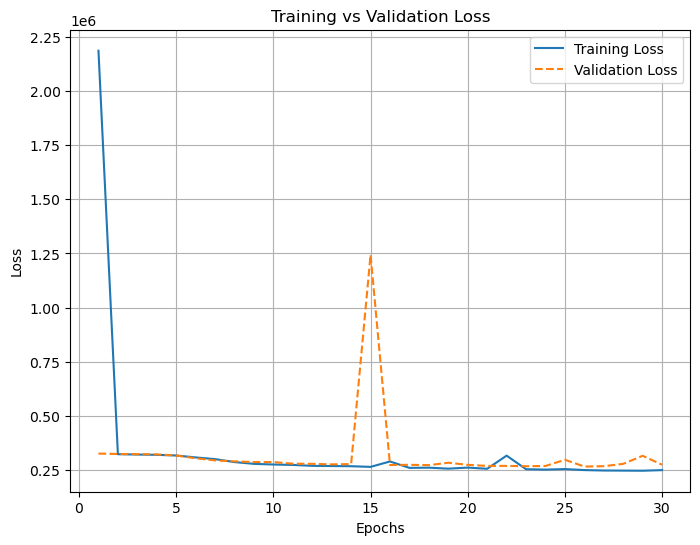

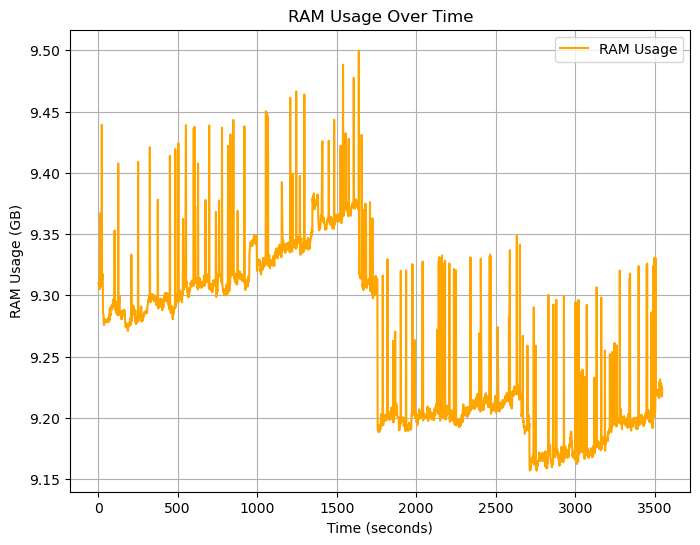

In [23]:
class SnowDepthCNNBest(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(SnowDepthCNNBest, self).__init__()
        self.relu = nn.ReLU()
        
        # Use 5 convolutional layers with the specified filter size (32)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)  # Final layer
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.conv5(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = SnowDepthCNNBest()
best_model = best_model.to(device)
criterion = nn.L1Loss(reduction='sum')
optimizer = torch.optim.RMSprop(best_model.parameters(), lr=0.001)

train_losses, val_losses, test_loss, test_mae, test_r2, test_rmse, loss_fig, ram_fig = train_and_evaluate_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
    device=device
)

In [ ]:
# well, i expected better but there's still a lot of potential here
# i can only imagine what optimzing a resnet might get us, especially when we can use
# all of the data and features we had to throw out
# and implement the gap maps

# 4. Performance Evaluation (20%)

#### Quantitative Evaluation (6%): 

In [ ]:
# quant evaluation was measured on the model's loss (MAE) after every run
# given that this is a regression problem and the goal is to develop a generalized model for 
# the western US, I want to rely on MAE as the main evaluation metric for hyperparameter tuning

In [ ]:
# the test loss is promising and the MAE of < 0.6 meters isn't bad considering current snow depth models
# at a similar scale, but 0.5 meters is still unacceptable
# The R2 score is weak and so is the corresponding correlation value, but it's not the worst I've seen
# and at least there's some relationship there
# I haven't worked much with PSNR much but I'm assuming it's a somewhat-decent score
# The MAPE indicatest that we need to handle zero values better, this makes sense given the physics
# of predicting small snow depths with satellite observations but this is a big part of what we're hoping
# to improve upon

#### Generalization Testing (7%): Evaluates model performance on unseen or out-of-distribution data and discusses overfitting or underfitting tendencies.

In [ ]:
# actually a bit unsure how to do this...

In [63]:
model = SnowDepthCNN()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
# Implement k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)

#### Discussion on Narrow vs. General AI (4%): Reflects on the role of the implemented models as narrow AI and contrasts this with the broader concept of general AI, tying the discussion to the problem domain and dataset.

In [ ]:
# here, I should just test and train on the sierra nevadas and rockies and see how it performs over those two regions

#### Visualization of Results (3%): Uses visualizations like confusion matrices, ROC curves, loss vs. epoch plots, or spatial/temporal error maps.

In [ ]:
# seems pretty straightforward

# 5. Software Delivery and Code Quality (20%)

#### Standard Practice for Training Neural Networks (10%):

Code is modular and organized in a single notebook.

Includes components like Dataset, DataLoader, model design as a class, training function, and training loop.

Explores training parameters and visualizes learning curves.

In [ ]:
# check-ish, not the most organized but it works
# go back and standardize the formatting and make it more readable and include
# PSNR and MAE on model evaluations
# and include plots

#### Saving Results (5%):

Saves model weights, training logs, and performance metrics to a CSV/JSON file.

In [ ]:
# done, see notebooks/weights for JSONs

#### Code Quality and Documentation (5%):

Follows best practices for readability, commenting, and modularity, ensuring reproducibility.

In [ ]:
# again, not the best but hopefully I can clean this up

# 6. Reporting and Interpretation (5%)

#### Scientific Communication (3%): Presents results clearly and concisely in a well-structured report or notebook, with appropriate figures, tables, and explanations

In [ ]:
# if you have the time, then summarize some results in a few code cells here 
# though, not worth hours of your time for 3% if it comes to be too much

#### Domain Insights (2%): Discusses implications of findings for geoscience, such as physical relevance, data limitations, or potential for real-world applications

In [ ]:
# Easy, quick writeup

# 7. Ethical and Computational Considerations (5%)

#### Computational Efficiency (3%): Documents computational costs (e.g., training time, memory usage) and discusses their impact on model choice.

In [ ]:
# touched on this testing different model architectures, but maybe make a df that shows this and such

#### Ethical Considerations (2%): Reflects on ethical implications, including biases in data, transparency of model predictions, and alignment with societal goals.

In [ ]:
# quick little writeup on ASO and WUS coverage and such